In [1]:
class logReturn:
    def __init__(self):
        pass
    def fit(self, df, windows:int=0):
        self.df = copy.deepcopy(df)
        self.rdf = copy.deepcopy(df)
        self.windows = windows
        self.transformR()
        self.rollingWindow()
    def transformR(self):
        self.lr = np.log(self.df/self.df.shift(1))
        return self
    def backwardR(self, logR, pred:bool=False):
        if pred:
            return np.exp(logR) * self.df[self.windows:].shift(1)
        else:
            return np.exp(logR) * self.df.shift(1)
    def rollingWindow(self):
        rolling = len(self.lr) - self.windows
        self.rollingX = np.array([self.lr[i: i+self.windows] for i in range(rolling)])
        self.rollingY = np.array([self.lr[i+self.windows] for i in range(rolling)])
        return self

In [2]:
def plotter(y_true, y_pred, fname, mse, r2):
    plt.figure(figsize=(20, 5))
    plt.plot(y_true, color='#C5171C', label='True')
    plt.plot(y_pred, color='black', linewidth=2, label='Pred')
    plt.title(f'{fname}', fontsize=30, fontweight='bold')
    plt.suptitle(f'\n\nMSE: {round(mse, 1)} R^2: {round(r2, 6)}', fontsize=20, fontweight='bold')
    plt.legend(fontsize=20,prop=dict(weight='bold'))
    plt.savefig(f'./Images/{fname}.png', bbox_inches='tight')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import copy

In [4]:
df = pd.read_csv('./Data/CleanBTCUSDT_1M.csv')
df = df[round(df.shape[0]/1.1):]
# df = df[round(df.shape[0]/1.05):]
df.reset_index(drop=True, inplace=True)

In [5]:
df

timestamp      open      high       low     close     volume
0       2021-08-01 02:31:00  41724.15  41727.21  41703.56  41710.41  10.234321
1       2021-08-01 02:32:00  41710.41  41719.33  41709.00  41716.37   7.599592
2       2021-08-01 02:33:00  41716.38  41716.38  41686.40  41694.00   9.061040
3       2021-08-01 02:34:00  41694.01  41700.00  41642.04  41642.05  18.491830
4       2021-08-01 02:35:00  41642.04  41686.29  41642.04  41680.00  31.642016
...                     ...       ...       ...       ...       ...        ...
207257  2021-12-23 07:18:00  48399.24  48407.98  48384.86  48390.19  16.975530
207258  2021-12-23 07:19:00  48390.20  48417.98  48390.19  48417.98   9.188340
207259  2021-12-23 07:20:00  48417.97  48439.82  48406.19  48430.60   7.366720
207260  2021-12-23 07:21:00  48430.61  48442.00  48419.95  48425.96   6.630590
207261  2021-12-23 07:22:00  48425.97  48450.00  48421.11  48437.57   6.360080

[207262 rows x 6 columns]

In [6]:
windows=10

LR = logReturn()
LR.fit(df.close, windows=windows)

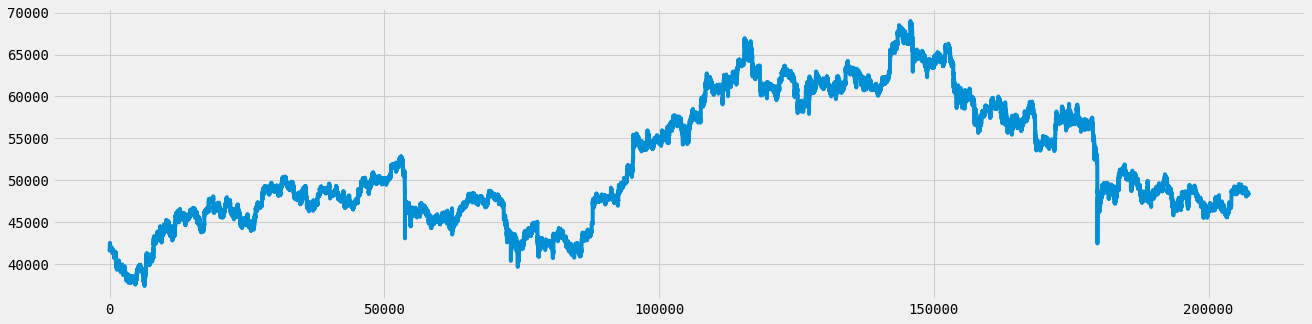

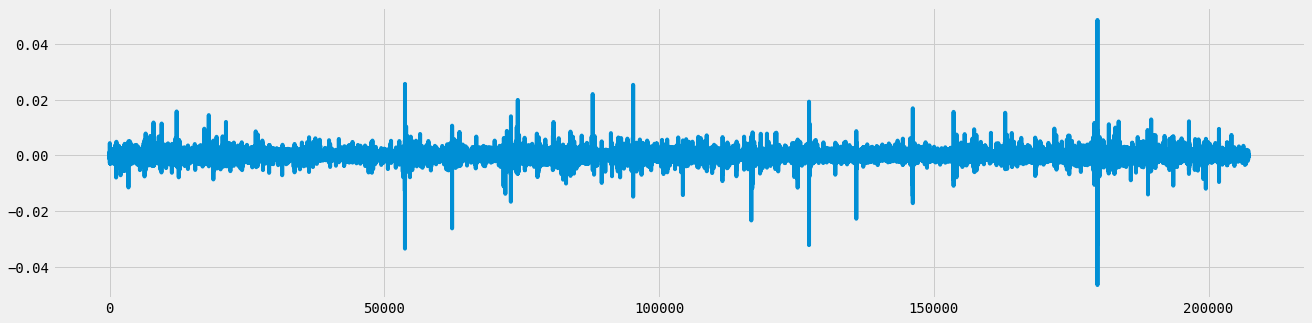

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = ["monospace"]

plt.figure(figsize=(20, 5))
df.close.plot()
plt.savefig(f'./Images/raw.png', bbox_inches='tight')

plt.figure(figsize=(20, 5))
LR.lr.plot()
plt.savefig(f'./Images/rawlr.png', bbox_inches='tight')

In [8]:
pd.DataFrame(
    {
        'True': df.close.values,
        'Backward': LR.backwardR(LR.lr).values
    }
)

True  Backward
0       41710.41       NaN
1       41716.37  41716.37
2       41694.00  41694.00
3       41642.05  41642.05
4       41680.00  41680.00
...          ...       ...
207257  48390.19  48390.19
207258  48417.98  48417.98
207259  48430.60  48430.60
207260  48425.96  48425.96
207261  48437.57  48437.57

[207262 rows x 2 columns]

In [9]:
zoom = 100
# LR.lr # 純粹的對數報酬率
x, y = LR.rollingX, LR.rollingY # 使用Rolling-Window後

In [10]:
import talib

Low = df["low"].shift(1)
High = df["high"].shift(1) 
Open = df["open"].shift(1) 
Close = df["close"].shift(1)  
Volume = df["volume"].shift(1)

df["low-lag1"] = df["low"].shift(1)
df["high-lag1"] = df["high"].shift(1) 
df["open-lag1"] = df["open"].shift(1) 
df["close-lag1"] = df["close"].shift(1)  
df["volume-lag1"] = df["volume"].shift(1)

df.loc[:, ('MA10')]  = talib.MA(Close, timeperiod=10).copy()
df.loc[:, ('WMA10')] = talib.WMA(Close, timeperiod=10).copy()
df.loc[:, ('EMA10')] = talib.EMA(Close, timeperiod=10).copy()
df.loc[:, ('MOM')] = talib.MOM(Close, timeperiod=10).copy()
fastk, fastd = talib.STOCHF( High ,Low, Close, fastk_period=5, fastd_period=3, fastd_matype=0)
df.loc[:, ('K')] = fastk.copy()
df.loc[:, ('D')] = fastd.copy()
df.loc[:, ('RSI-5')]  = talib.RSI(Close,timeperiod=5).copy()
df.loc[:, ('RSI-10')] = talib.RSI(Close,timeperiod=10).copy()
df.loc[:, ('威廉指標R')] = talib.WILLR(High, Low, Close, timeperiod=10).copy() # 14 --> 10
df.loc[:, ('AD')] = talib.AD(High, Low, Close, Volume).values.copy()
df.loc[:, ('CCI指標')] = talib.CCI(High, Low, Close, timeperiod=10).copy()

In [11]:
df.iloc[windows:, 6:]

low-lag1  high-lag1  open-lag1  close-lag1  volume-lag1       MA10  \
10      41670.02   41697.43   41672.43    41696.46    17.412166  41678.369   
11      41689.00   41720.00   41696.46    41719.31    28.946756  41679.259   
12      41705.99   41728.00   41719.31    41714.18    11.990939  41679.040   
13      41715.88   41730.00   41715.89    41718.40    26.568071  41681.480   
14      41701.84   41725.09   41718.40    41722.28    17.910664  41689.503   
...          ...        ...        ...         ...          ...        ...   
207257  48399.23   48408.02   48402.24    48399.23     4.840940  48440.982   
207258  48384.86   48407.98   48399.24    48390.19    16.975530  48431.087   
207259  48390.19   48417.98   48390.20    48417.98     9.188340  48427.207   
207260  48406.19   48439.82   48417.97    48430.60     7.366720  48423.552   
207261  48419.95   48442.00   48430.61    48425.96     6.630590  48419.101   

               WMA10         EMA10    MOM          K          D      RSI-5  \
10      41672.392364  41678.369000    NaN  98.310987  54.750242  56.439595   
11      41679.836182  41685.812818   8.90  99.137500  87.146076  64.885391   
12      41686.185455  41690.970488  -2.19  84.085675  93.844721  61.537073   
13      41693.341818  41695.957672  24.40  86.941349  90.054841  63.475160   
14      41700.760000  41700.743550  80.23  87.129043  86.052022  65.474558   
...              ...           ...    ...        ...        ...        ...   
207257  48426.396922  48429.330075 -91.30  23.005763  19.469406  18.906397   
207258  48417.162013  48422.213698 -98.95   9.296330  17.589296  15.785362   
207259  48414.778922  48421.443935 -38.80  64.955956  32.419349  48.471678   
207260  48415.395831  48423.108674 -36.55  83.464849  52.572378  57.774839   
207261  48415.833649  48423.627097 -44.51  71.928596  73.449800  53.348211   

           RSI-10      威廉指標R            AD       CCI指標  
10            NaN -35.259718      5.148386   28.753336  
11      51.892007  -0.862500     32.806545  106.689641  
12      50.664176 -15.704545     29.739349  128.665076  
13      51.708561 -12.888889     12.654498  122.258513  
14      52.730803  -8.577778     26.235789   84.300952  
...           ...        ...           ...         ...  
207257  38.177511 -86.905481  63362.925750 -110.098288  
207258  35.761051 -94.267278  63353.777173 -103.571435  
207259  47.180471 -68.278313  63362.965513  -52.329111  
207260  51.528205 -56.476199  63366.292913    4.679249  
207261  49.851851 -52.857786  63363.276822   35.891953  

[207252 rows x 16 columns]

In [12]:
(x.shape)

(207252, 10)

In [13]:
x_more = df.iloc[windows:, 6:].values
x_more_F = np.append(x, x_more, axis=1)
np.nan_to_num(x_more_F, 0)

array([[ 0.00000000e+00,  1.42879781e-04, -5.36384158e-04, ...,
        -3.52597179e+01,  5.14838617e+00,  2.87533360e+01],
       [ 1.42879781e-04, -5.36384158e-04, -1.24675952e-03, ...,
        -8.62500000e-01,  3.28065446e+01,  1.06689641e+02],
       [-5.36384158e-04, -1.24675952e-03,  9.10923402e-04, ...,
        -1.57045455e+01,  2.97393485e+01,  1.28665076e+02],
       ...,
       [ 2.13982244e-04,  6.84976586e-05, -5.40475018e-04, ...,
        -6.82783129e+01,  6.33629655e+04, -5.23291109e+01],
       [ 6.84976586e-05, -5.40475018e-04, -9.82620418e-05, ...,
        -5.64761994e+01,  6.33662929e+04,  4.67924853e+00],
       [-5.40475018e-04, -9.82620418e-05, -1.29035202e-04, ...,
        -5.28577858e+01,  6.33632768e+04,  3.58919532e+01]])

In [14]:
(x_more_F.shape, y.shape)

((207252, 26), (207252,))

In [15]:
outputs = {}
mse = {}

# **Train-Test-Split**

In [16]:
pct = 0.7
TrainSize = round(y.shape[0]*pct)
TestSize = y.shape[0] - TrainSize

X_train, y_train = x_more_F[:TrainSize], y[:TrainSize] # (145076, 26)
X_test, y_test = x_more_F[TrainSize:], y[TrainSize:] # (62176, 26)

In [17]:
X_train, y_train = x_more_F[:TrainSize], y[:TrainSize]
X_test, y_test = x_more_F[TrainSize:], y[TrainSize:]

In [18]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
ms.fit(X_train)
X_train_ms = ms.transform(X_train) # 訓練集
X_test_ms = ms.transform(X_test) # 測試集
X_ms = np.append(X_train_ms, X_test_ms, axis=0) # 訓練集 + 測試集 (207252, 26)

In [19]:
X_train_ms.shape, X_test_ms.shape

((145076, 26), (62176, 26))

In [20]:
len(X_train_ms)

145076

In [21]:
X_ms = np.append(X_train_ms, X_test_ms, axis=0)

In [22]:
X_ms.shape

(207252, 26)

# **Train**

## **RandomForest**

In [25]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100, criterion = 'squared_error')
RF.fit(X_train_ms, y_train)
RF_pred = RF.predict(X_ms)

In [26]:
RF_price = LR.backwardR(RF_pred, pred=True)
np.nan_to_num(RF_price, 0)

array([    0.        , 41720.25738742, 41711.91485993, ...,
       48413.57688198, 48432.85776828, 48423.63800331])

In [27]:
RF_mse = mean_squared_error(df.close[TrainSize+windows:], RF_price[TrainSize:])
RF_r2 = r2_score(df.close[windows+TrainSize:], RF_price[TrainSize:])

print(f'Score: {RF_r2}\nMSE: {RF_mse}')

Score: 0.999912589286483
MSE: 3232.5348498574735


In [28]:
outputs['RF'] = RF_price
mse['RF'] = RF_mse

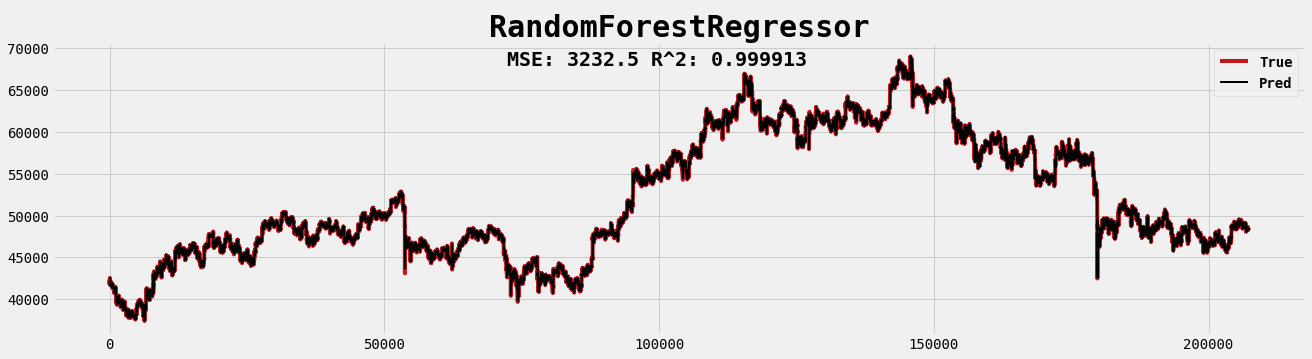

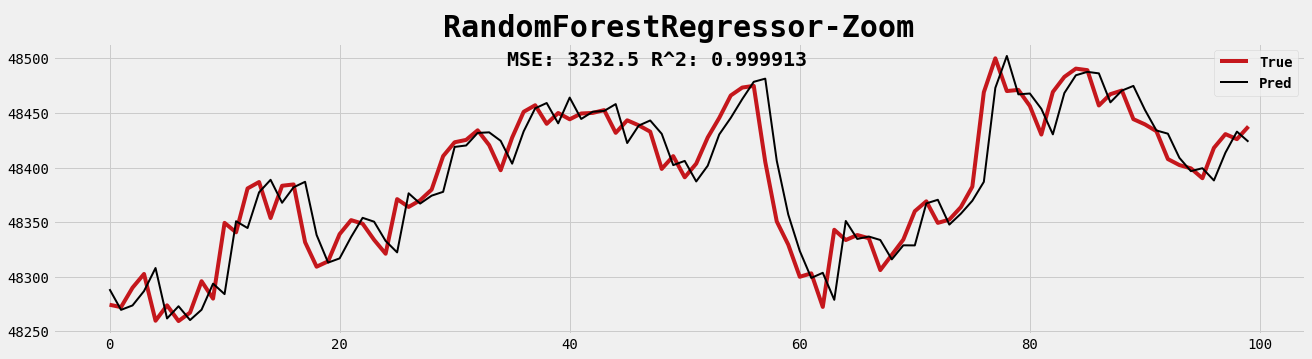

In [29]:
plotter(df.close[windows+1:].values, RF_price[1:], 'RandomForestRegressor', mse=RF_mse, r2=RF_r2)
plotter(df.close[windows+1:].values[-zoom:], RF_price[1:].values[-zoom:], 'RandomForestRegressor-Zoom', mse=RF_mse, r2=RF_r2)

## **KNN**

In [30]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=3)
KNN.fit(X_train_ms, y_train)
KNN_pred = KNN.predict(X_ms)

In [31]:
KNN_price = LR.backwardR(KNN_pred, pred=True)
np.nan_to_num(KNN_price, 0)

array([    0.        , 41724.90972496, 41724.81321225, ...,
       48436.10380628, 48482.88941362, 48420.85371872])

In [32]:
KNN_r2 = r2_score(df.close[TrainSize+windows:], KNN_price[TrainSize:])
KNN_mse = mean_squared_error(df.close[TrainSize+windows:], KNN_price[TrainSize:])

print(f'R2: {KNN_r2}\nMSE: {KNN_mse}')

R2: 0.9998935127281564
MSE: 3938.0048903684547


In [33]:
outputs['KNN'] = KNN_price
mse['KNN'] = KNN_mse

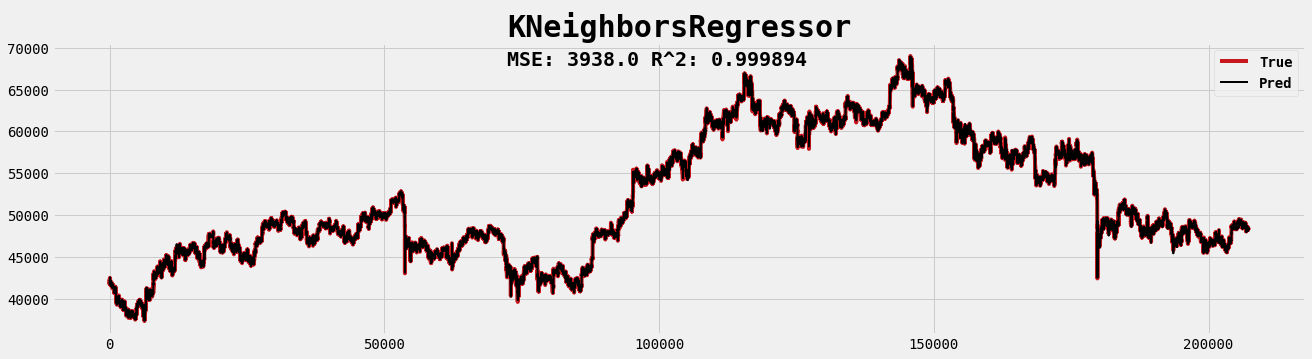

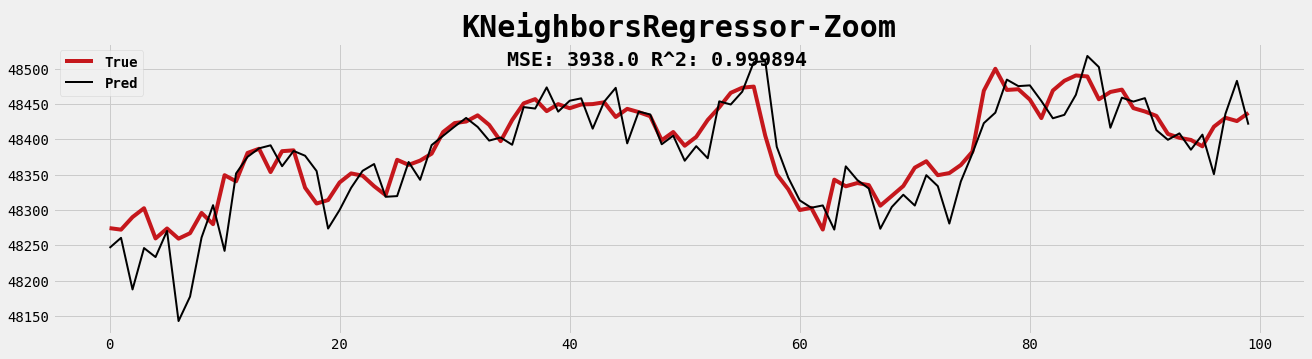

In [34]:
plotter(df.close[windows+1:].values, KNN_price[1:], 'KNeighborsRegressor', mse=KNN_mse, r2=KNN_r2)
plotter(df.close[windows+1:].values[-zoom:], KNN_price[1:].values[-zoom:], 'KNeighborsRegressor-Zoom', mse=KNN_mse, r2=KNN_r2)

## **xgboost**

```shell
conda install -c conda-forge xgboost
```

In [35]:
import xgboost as xgb

XGB = xgb.XGBRegressor()
XGB.fit(X_train_ms, y_train)
XGB_pred = XGB.predict(X_ms)

In [36]:
XGB_price = LR.backwardR(XGB_pred, pred=True)
np.nan_to_num(XGB_price, 0)

array([    0.        , 41717.97466108, 41712.25555823, ...,
       48417.33355022, 48431.14847085, 48424.80254873])

In [37]:
XGB_r2 = r2_score(df.close[TrainSize+windows:], XGB_price[TrainSize:])
XGB_mse = mean_squared_error(df.close[TrainSize+windows:], XGB_price[TrainSize:])
print(f'R2: {XGB_r2}\nMSE: {XGB_mse}')

R2: 0.9999047514907486
MSE: 3522.384306952574


In [38]:
outputs['XGB'] = XGB_price
mse['XGB'] = XGB_mse

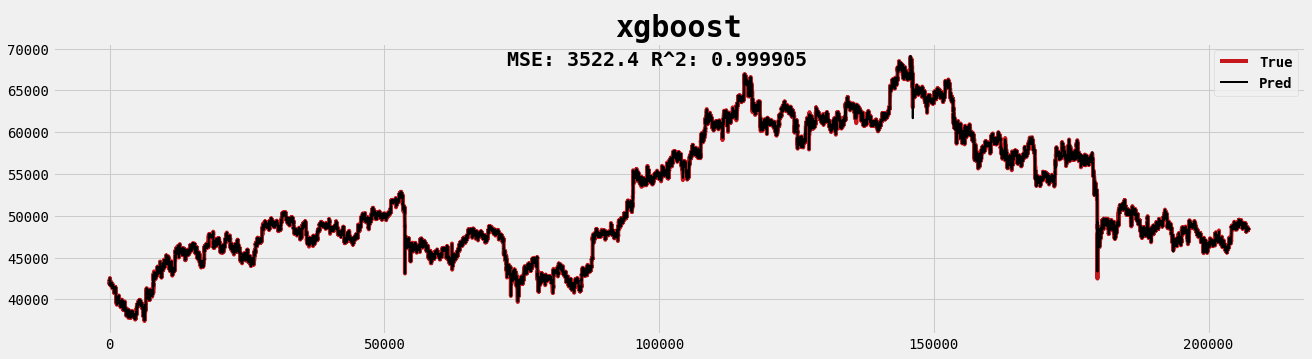

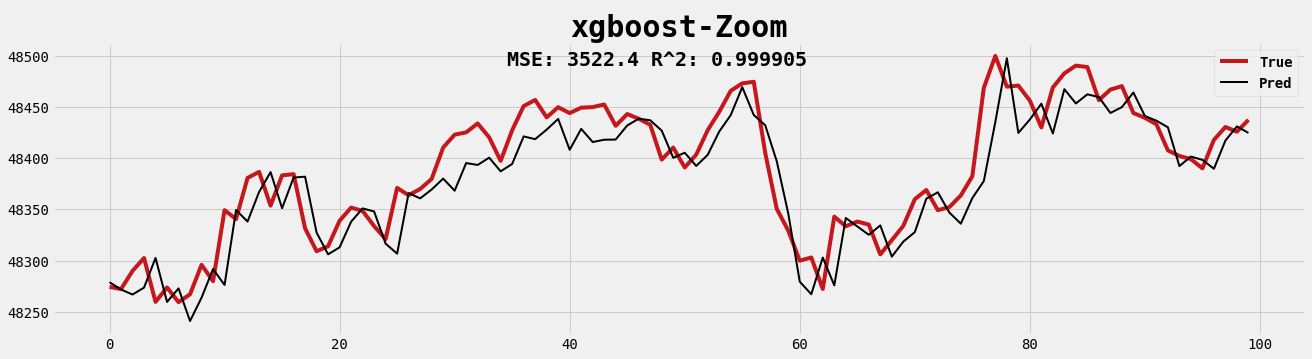

In [39]:
plotter(df.close[windows+1:].values, XGB_price[1:].values, 'xgboost', mse=XGB_mse, r2=XGB_r2)
plotter(df.close[windows+1:].values[-zoom:], XGB_price[1:].values[-zoom:], 'xgboost-Zoom', mse=XGB_mse, r2=XGB_r2)

In [40]:
outputs_df = pd.DataFrame(outputs)
mse_df = pd.DataFrame(mse, index=[0])

In [41]:
outputs_df.to_csv('./Data/ouputs_r.csv', index=False)
mse_df.to_csv('./Data/mse_r.csv', index=False)

In [42]:
pd.DataFrame(
    {
        y[0]: x[0],
        y[1]: x[1]
    }
).T

0         1         2         3         4         5  \
 0.000548       NaN  0.000143 -0.000536 -0.001247  0.000911 -0.000163   
-0.000123  0.000143 -0.000536 -0.001247  0.000911 -0.000163 -0.000374   

                  6         7         8         9  
 0.000548 -0.000374 -0.000394  0.000750  0.000576  
-0.000123 -0.000394  0.000750  0.000576  0.000548

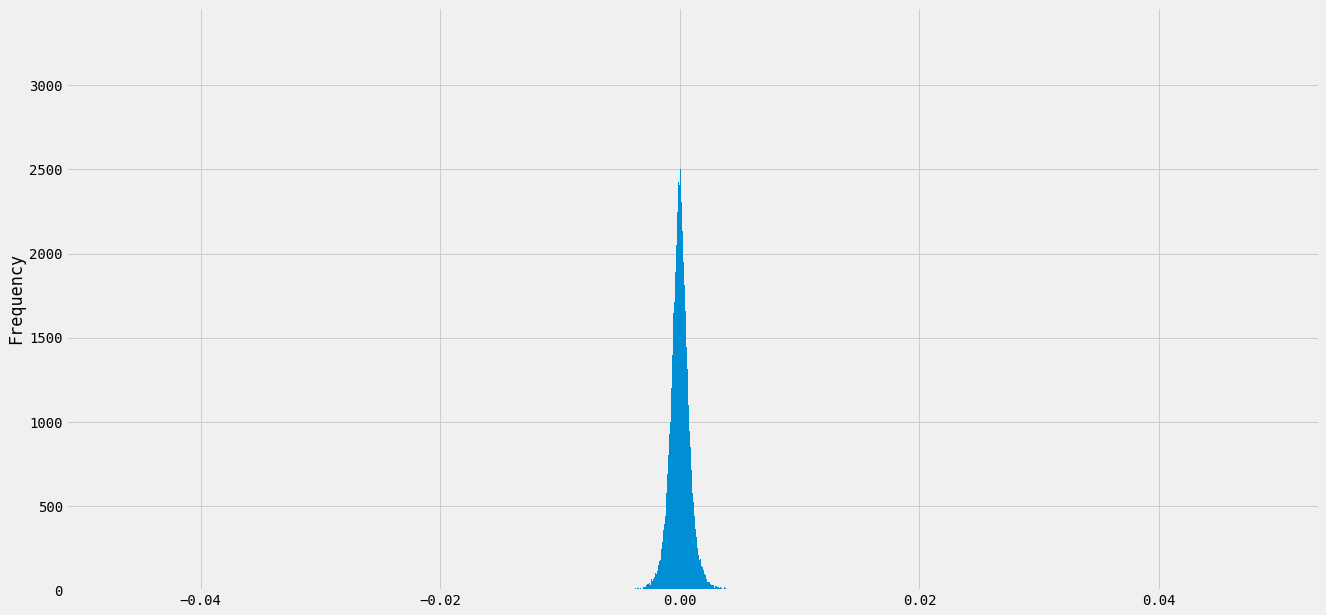

In [43]:
plt.figure(figsize=(20, 10))
LR.lr.plot(kind='hist', bins=5000)
# plt.xscale('log')
plt.savefig(f'./Images/rawnd.png', bbox_inches='tight')

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization
from keras.models import Sequential
times= 50
unit= 100
my_model = Sequential()
my_model.add(LSTM(units = unit, input_shape= (26,1)))
my_model.add(Dropout(0.5))
my_model.add(Dense(100, activation='relu', input_dim= (26,1)))
my_model.add(Dense(1))
my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()
history= my_model.fit(X_train_ms,y_train,epochs= times)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4534/4534 [==============================] - 44s 8ms/step - loss: 1.3226e-05 - mean_squared_error: 1.3226e-05
Epoch 2/50
4534/4534 [==============================] - 41s 9ms

In [27]:
LSTM_pred = my_model.predict(X_ms)

In [33]:
LSTM_price = LR.backwardR(LSTM_pred.reshape(-1), pred=True)
np.nan_to_num(LSTM_price, 0)

array([    0.        , 41711.07665333, 41705.94766575, ...,
       48408.42466425, 48421.04217368, 48416.40308939])

In [34]:
LSTM_r2 = r2_score(df.close[TrainSize+windows:], LSTM_price[TrainSize:])
LSTM_mse = mean_squared_error(df.close[TrainSize+windows:], LSTM_price[TrainSize:])

print(f'R2: {LSTM_r2}\nMSE: {LSTM_mse}')

R2: 0.9999108111619603
MSE: 3298.2916576417347


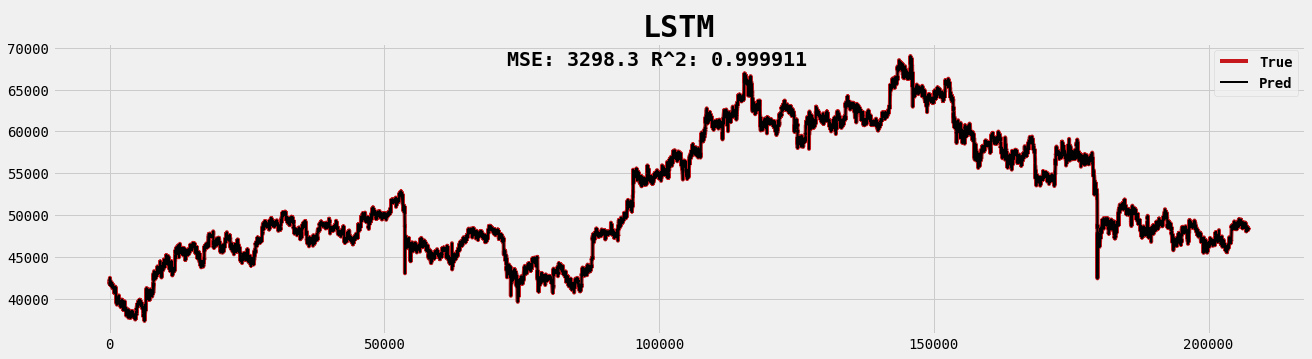

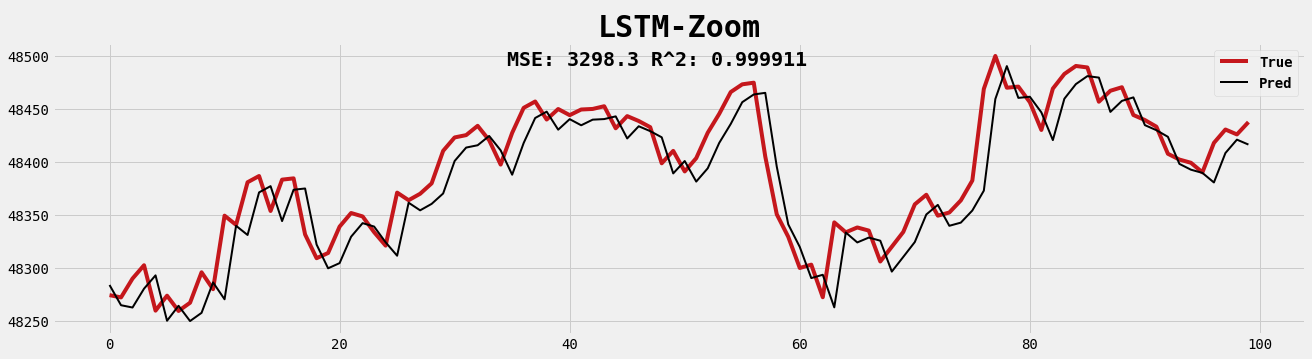

In [36]:
plotter(df.close[windows+1:].values, LSTM_price[1:].values, 'LSTM', mse=LSTM_mse, r2=LSTM_r2)
plotter(df.close[windows+1:].values[-zoom:], LSTM_price[1:].values[-zoom:], 'LSTM-Zoom', mse=LSTM_mse, r2=LSTM_r2)